In [1]:
# To unzip
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Colab Notebooks/Melanoma_Skin_Cancer_Detection/dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


# Split dataset to Train, Validate and Test

In [2]:
!pip install split-folders

import splitfolders
splitfolders.ratio(r"/content/processed/train",
                   'data',
                   seed = 41,
                   ratio = (0.6, 0.25, 0.15)) # train/val/test

Copying files: 9605 files [00:02, 4233.01 files/s]


# Start to Training

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNet, ResNet50, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [5]:
# Function to create a model with a given base model
def create_transfer_learning_model(base_model, num_classes):
    base_model.trainable = False  # Freeze base model layers
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Function to train a specific model
def train_model(model, train_generator, val_generator, epochs=10, learning_rate=0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy' if train_generator.num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        steps_per_epoch=100)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    accuracy_image_path = 'accuracy_plot.png'
    plt.plot(epochs, acc, label='training accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training validation Accuracy')
    plt.savefig(accuracy_image_path, bbox_inches='tight')
    plt.show()

    loss_image_path = 'loss_plot.png'
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training validation Loss')
    plt.savefig(loss_image_path, bbox_inches='tight')
    plt.show()

    return model, history

# Functions to create specific models
def create_vgg16_model(num_classes):
    return create_transfer_learning_model(VGG16(weights='imagenet', include_top=False), num_classes)

def create_mobilenet_model(num_classes):
    return create_transfer_learning_model(MobileNet(weights='imagenet', include_top=False), num_classes)

def create_resnet50_model(num_classes):
    return create_transfer_learning_model(ResNet50(weights='imagenet', include_top=False), num_classes)

def create_densenet_model(num_classes):
    return create_transfer_learning_model(DenseNet121(weights='imagenet', include_top=False), num_classes)

def create_inceptionv3_model(num_classes):
    return create_transfer_learning_model(InceptionV3(weights='imagenet', include_top=False), num_classes)

# Function to save the model
def save_model(model, filepath):
    model.save(filepath)
    print(f"Model saved to {filepath}")

# Function to load the model
def load_model(filepath):
    model = tf.keras.models.load_model(filepath)
    print(f"Model loaded from {filepath}")
    return model

# Function to evaluate the model
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)

    predicted_classes = np.argmax(predictions, axis=1) if test_generator.num_classes > 1 else (predictions > 0.5).astype(int)

    # Handle binary and multiclass cases
    # if test_generator.num_classes > 1:  # Multiclass classification
    #     predicted_classes = np.argmax(predictions, axis=1)
    # else:  # Binary classification
    #     predicted_classes = (predictions > 0.5).astype(int).flatten()

    true_classes = test_generator.classes
    # class_indices = test_generator.class_indices

    # Metrics
    acc = accuracy_score(true_classes, predicted_classes)
    loss = 1 - acc
    cm = confusion_matrix(true_classes, predicted_classes)
    cr = classification_report(true_classes, predicted_classes)
    kappa = cohen_kappa_score(true_classes, predicted_classes)

    print(f"Accuracy: {acc}")
    print(f"Loss: {loss}")
    print(f"Cohen Kappa Score: {kappa}")
    print("Classification Report:")
    print(cr)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    return acc, kappa, cm, cr

# Function to prepare data generators
def prepare_data_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255)
    train_generator = datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
    val_generator = datagen.flow_from_directory(val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
    test_generator = datagen.flow_from_directory(test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
    return train_generator, val_generator, test_generator


# VGG16

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - accuracy: 0.7375 - loss: 0.5306 - val_accuracy: 0.8634 - val_loss: 0.3197
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8519 - loss: 0.3275

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.8527 - loss: 0.3260 - val_accuracy: 0.8688 - val_loss: 0.3015
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - accuracy: 0.8529 - loss: 0.3372 - val_accuracy: 0.8676 - val_loss: 0.2896
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.8713 - loss: 0.2997 - val_accuracy: 0.8713 - val_loss: 0.2818
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 264ms/step - accuracy: 0.8572 - loss: 0.3176 - val_accuracy: 0.8796 - val_loss: 0.2763
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - accuracy: 0.8794 - loss: 0.2785 - val_accuracy: 0.8713 - val_loss: 0.2844
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 216ms/step - accuracy: 0.8822 - loss: 0.2793 - val_accuracy: 0.8813 - val_loss: 0.2712
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - accuracy: 0.8937 - loss: 0.2591 - val_accuracy: 0.8825 - val_loss: 0.2685
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 215ms/step - accuracy: 0.8931 - loss: 0.262

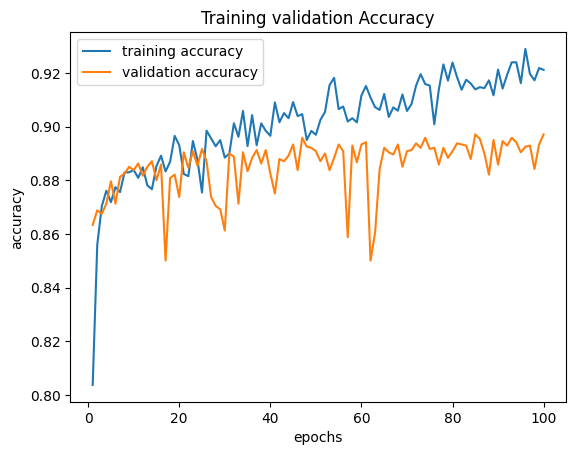

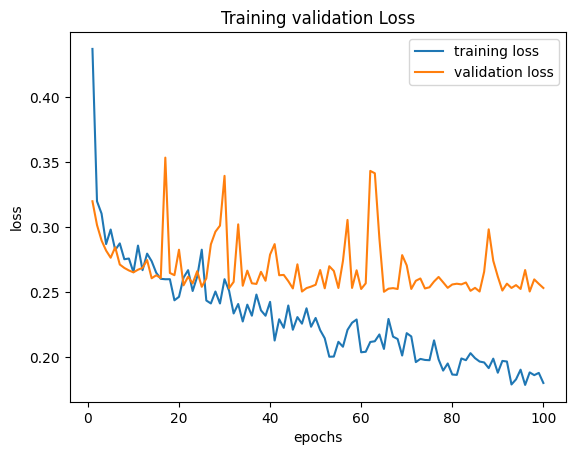

Model saved to vgg16_model.h5
Model loaded from vgg16_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step
Accuracy: 0.9042331714087439
Loss: 0.09576682859125607
Cohen Kappa Score: 0.8077288258829035
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       750
           1       0.92      0.87      0.90       691

    accuracy                           0.90      1441
   macro avg       0.91      0.90      0.90      1441
weighted avg       0.91      0.90      0.90      1441



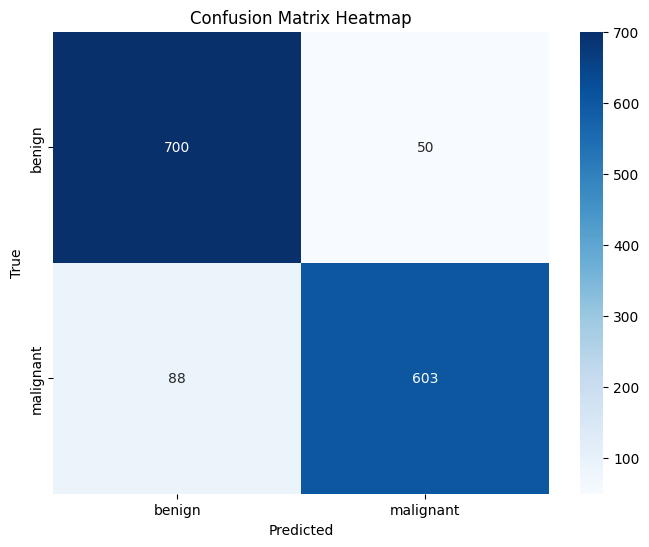

In [6]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    vgg16_model = create_vgg16_model(num_classes)
    trained_vgg16, _ = train_model(vgg16_model, train_gen, val_gen, epochs=100)
    save_model(trained_vgg16, "vgg16_model.h5")
    # save_model(trained_vgg16, "vgg16_model.keras")

    # Load and evaluate VGG16 model
    loaded_vgg16 = load_model("vgg16_model.h5")
    evaluate_model(loaded_vgg16, test_gen)

# Mobilenet

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.


<ipython-input-5-f21aaace84f0>:59: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  return create_transfer_learning_model(MobileNet(weights='imagenet', include_top=False), num_classes)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 183ms/step - accuracy: 0.7672 - loss: 0.4624 - val_accuracy: 0.8546 - val_loss: 0.3503
Epoch 2/100
 80/100 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8697 - loss: 0.3258

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.8720 - loss: 0.3198 - val_accuracy: 0.8871 - val_loss: 0.2700
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.8960 - loss: 0.2677 - val_accuracy: 0.8838 - val_loss: 0.2743
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8939 - loss: 0.2542 - val_accuracy: 0.8809 - val_loss: 0.3005
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.8945 - loss: 0.2514 - val_accuracy: 0.8759 - val_loss: 0.2876
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.8935 - loss: 0.2507 - val_accuracy: 0.8684 - val_loss: 0.3186
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.8982 - loss: 0.2325 - val_accuracy: 0.8930 - val_loss: 0.2523
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.9114 - loss: 0.2137 - val_accuracy: 0.8776 - val_loss: 0.2888
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.9215 - loss: 0.201

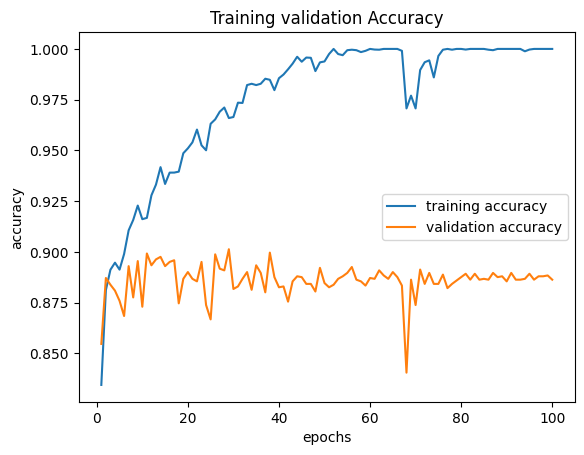

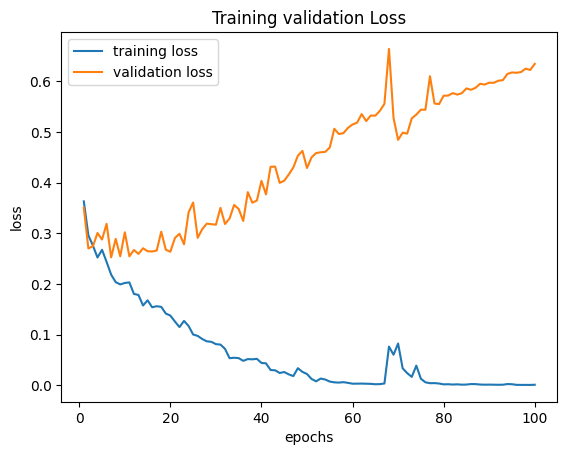

Model saved to mobilenet_model.h5


Model loaded from mobilenet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step
Accuracy: 0.8993754337265788
Loss: 0.1006245662734212
Cohen Kappa Score: 0.7985849033868815
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       750
           1       0.89      0.91      0.90       691

    accuracy                           0.90      1441
   macro avg       0.90      0.90      0.90      1441
weighted avg       0.90      0.90      0.90      1441



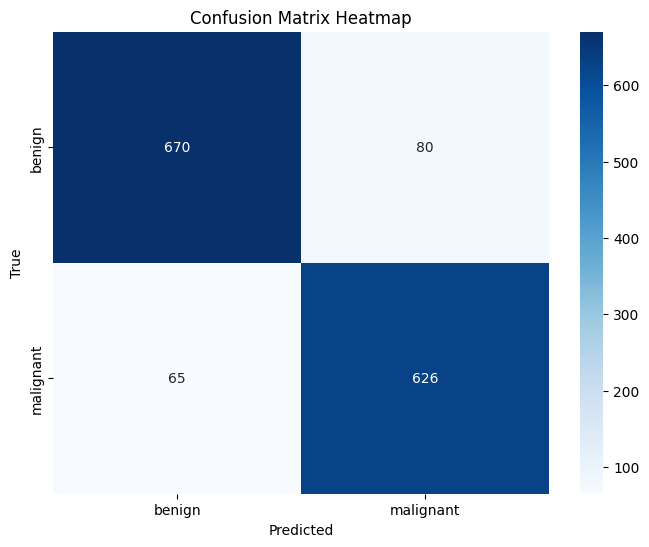

In [8]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    mobilenet_model = create_mobilenet_model(num_classes)
    trained_mobilenet, _ = train_model(mobilenet_model, train_gen, val_gen, epochs=100)
    save_model(trained_mobilenet, "mobilenet_model.h5")

    # Load and evaluate VGG16 model
    loaded_mobilenet = load_model("mobilenet_model.h5")
    evaluate_model(loaded_mobilenet, test_gen)

# Resnet50

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 231ms/step - accuracy: 0.6285 - loss: 0.6316 - val_accuracy: 0.7697 - val_loss: 0.4680
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.7837 - loss: 0.4654

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.7801 - loss: 0.4679 - val_accuracy: 0.7738 - val_loss: 0.4474
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 168ms/step - accuracy: 0.7762 - loss: 0.4646 - val_accuracy: 0.7680 - val_loss: 0.4550
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.7784 - loss: 0.4545 - val_accuracy: 0.7830 - val_loss: 0.4314
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - accuracy: 0.7948 - loss: 0.4337 - val_accuracy: 0.7518 - val_loss: 0.4809
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - accuracy: 0.7669 - loss: 0.4438 - val_accuracy: 0.7426 - val_loss: 0.5202
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.7653 - loss: 0.4601 - val_accuracy: 0.7743 - val_loss: 0.4366
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.7916 - loss: 0.4233 - val_accuracy: 0.7872 - val_loss: 0.4145
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.8018 - loss: 0.420

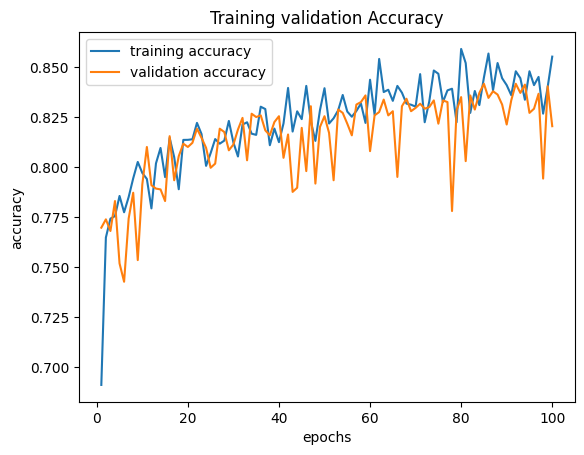

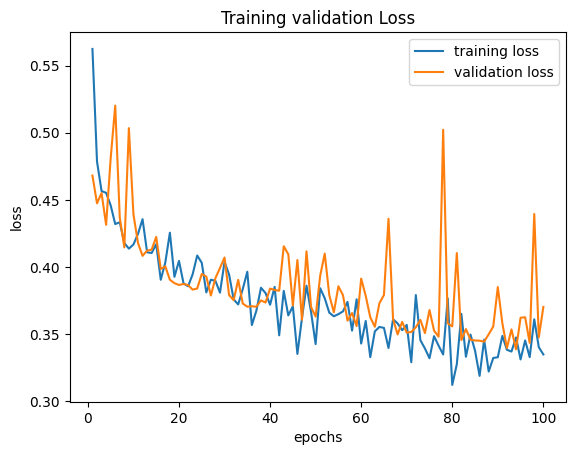

Model saved to resnet50_model.h5


Model loaded from resnet50_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step
Accuracy: 0.8320610687022901
Loss: 0.16793893129770987
Cohen Kappa Score: 0.6659917322125717
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       750
           1       0.77      0.92      0.84       691

    accuracy                           0.83      1441
   macro avg       0.84      0.84      0.83      1441
weighted avg       0.84      0.83      0.83      1441



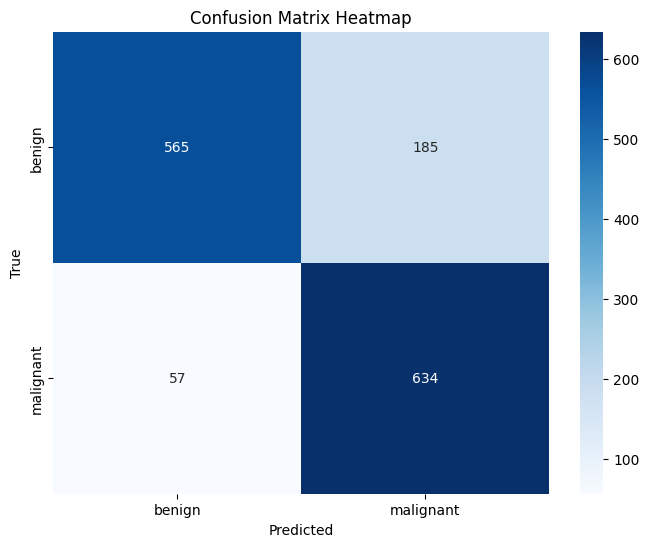

In [10]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    resnet50_model = create_resnet50_model(num_classes)
    trained_resnet50, _ = train_model(resnet50_model, train_gen, val_gen, epochs=100)
    save_model(trained_resnet50, "resnet50_model.h5")

    # Load and evaluate VGG16 model
    loaded_resnet50 = load_model("resnet50_model.h5")
    evaluate_model(loaded_resnet50, test_gen)

# Densenet

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 341ms/step - accuracy: 0.8087 - loss: 0.3930 - val_accuracy: 0.8563 - val_loss: 0.3371
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8742 - loss: 0.3042

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.8762 - loss: 0.3001 - val_accuracy: 0.8821 - val_loss: 0.2802
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8788 - loss: 0.2949 - val_accuracy: 0.8971 - val_loss: 0.2515
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.8990 - loss: 0.2535 - val_accuracy: 0.8934 - val_loss: 0.2581
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.9025 - loss: 0.2480 - val_accuracy: 0.8975 - val_loss: 0.2523
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.9048 - loss: 0.2259 - val_accuracy: 0.9000 - val_loss: 0.2458
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.9098 - loss: 0.2103 - val_accuracy: 0.8980 - val_loss: 0.2470
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9075 - loss: 0.2220 - val_accuracy: 0.9009 - val_loss: 0.2450
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.9047 - loss: 0.215

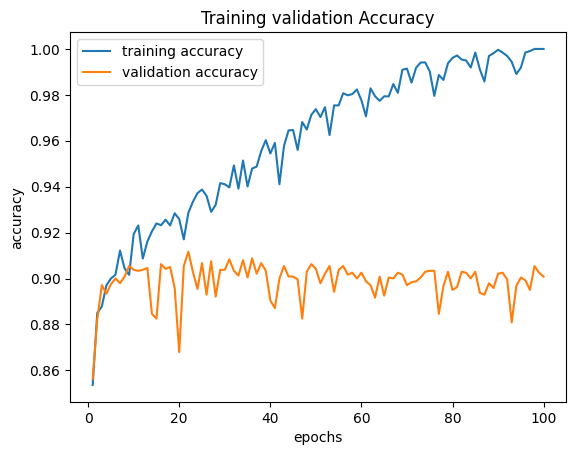

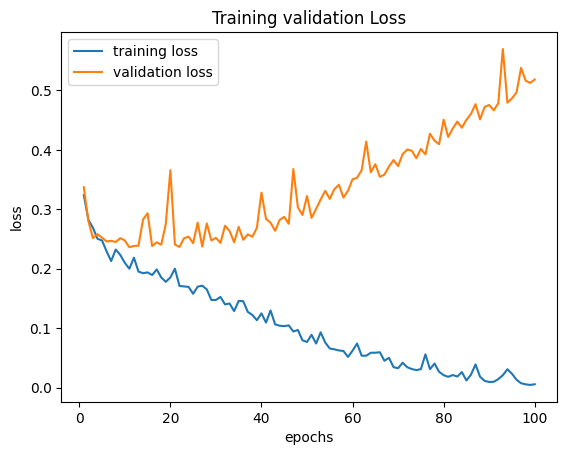

Model saved to densenet_model.h5


Model loaded from densenet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step
Accuracy: 0.8896599583622484
Loss: 0.11034004163775157
Cohen Kappa Score: 0.7790373927224367
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       750
           1       0.88      0.89      0.89       691

    accuracy                           0.89      1441
   macro avg       0.89      0.89      0.89      1441
weighted avg       0.89      0.89      0.89      1441



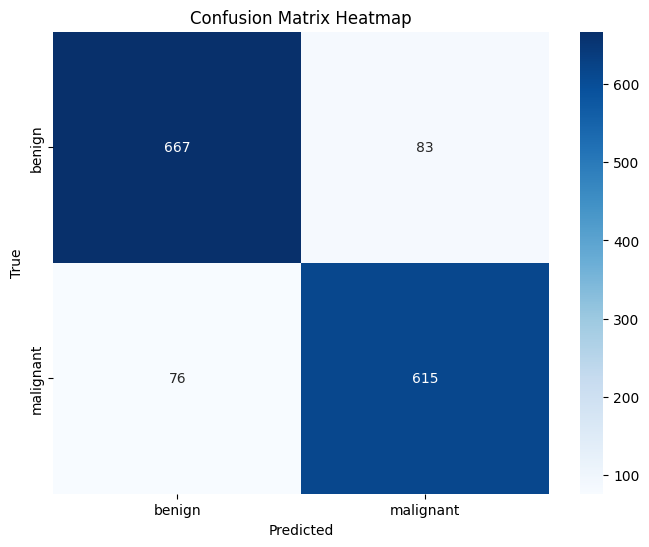

In [12]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    densenet_model = create_densenet_model(num_classes)
    trained_densenet, _ = train_model(densenet_model, train_gen, val_gen, epochs=100)
    save_model(trained_densenet, "densenet_model.h5")

    # Load and evaluate VGG16 model
    loaded_densenet = load_model("densenet_model.h5")
    evaluate_model(loaded_densenet, test_gen)

# Inceptionv3

In [ ]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    inceptionv3_model = create_inceptionv3_model(num_classes)
    trained_inceptionv3, _ = train_model(inceptionv3_model, train_gen, val_gen, epochs=100)
    save_model(trained_inceptionv3, "inceptionv3_model.h5")

    # Load and evaluate VGG16 model
    loaded_inceptionv3 = load_model("inceptionv3_model.h5")
    evaluate_model(loaded_inceptionv3, test_gen)

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 269ms/step - accuracy: 0.7467 - loss: 0.6546 - val_accuracy: 0.8576 - val_loss: 0.3232
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.8549 - loss: 0.3307

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.8562 - loss: 0.3278 - val_accuracy: 0.8559 - val_loss: 0.3184
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.8930 - loss: 0.2603 - val_accuracy: 0.8688 - val_loss: 0.2945
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.8923 - loss: 0.2526 - val_accuracy: 0.8684 - val_loss: 0.3018
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.8801 - loss: 0.2834 - val_accuracy: 0.8676 - val_loss: 0.2876
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.8848 - loss: 0.2696 - val_accuracy: 0.8742 - val_loss: 0.2781
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - accuracy: 0.8961 - loss: 0.2505 - val_accuracy: 0.8626 - val_loss: 0.2969
Epoch 8/100
 33/100 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9032 - loss: 0.2272